# **Speech**

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Function to extract RMS, ZCR, and MFCC features
def extract_features(file_path, n_mfcc=40, max_pad_length=200):
    audio, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=audio)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
    features = np.vstack([rms, zcr, mfcc, mfcc_delta, mfcc_delta2])
    features = librosa.power_to_db(features, ref=np.max)

    if features.shape[1] < max_pad_length:
        pad_width = max_pad_length - features.shape[1]
        features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :max_pad_length]

    return features.T  # Shape (200, feature_dim)

# Load dataset
dataset_path = "/kaggle/input/ravdess-emotional-speech-audio"

def load_data(dataset_path):
    file_paths = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_paths.append(os.path.join(root, file))
                labels.append(file.split('-')[2])  # Extract emotion label from filename
    return file_paths, labels

file_paths, labels = load_data(dataset_path)
features = [extract_features(file) for file in file_paths]

X = np.array(features, dtype=np.float32)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Save Label Encoder
np.save("/kaggle/working/label_classes.npy", label_encoder.classes_)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X.shape[2])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X.shape[2])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X.shape[2])).reshape(X_test.shape)

# Save Scaler Parameters
np.save("/kaggle/working/scaler_mean.npy", scaler.mean_)
np.save("/kaggle/working/scaler_scale.npy", scaler.scale_)

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_categorical.shape[1]

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Function to build an LSTM model
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(512, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.4),

        LSTM(256, return_sequences=True),
        BatchNormalization(),
        Dropout(0.4),

        LSTM(128, return_sequences=True),
        Dropout(0.4),

        LSTM(64),
        Dropout(0.3),

        Dense(128, activation='swish'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build a BiLSTM model
def build_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(512, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.4),

        LSTM(256, return_sequences=True),
        BatchNormalization(),
        Dropout(0.4),

        LSTM(128, return_sequences=True),
        Dropout(0.4),

        LSTM(64),
        Dropout(0.3),

        Dense(128, activation='swish'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and Save LSTM Model
lstm_model = build_lstm_model(input_shape, num_classes)
lstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, 
               validation_data=(X_val_scaled, y_val), callbacks=[reduce_lr])
lstm_model.save("/kaggle/working/lstm_model_speech.h5")  # Save LSTM model

# Train and Save BiLSTM Model
bilstm_model = build_bilstm_model(input_shape, num_classes)
bilstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, 
                 validation_data=(X_val_scaled, y_val), callbacks=[reduce_lr])
bilstm_model.save("/kaggle/working/bilstm_model_speech.h5")  # Save BiLSTM model

# Evaluate Models
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_scaled, y_test)
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test_scaled, y_test)

print(f"LSTM Model - Loss: {lstm_loss}, Accuracy: {lstm_accuracy}")
print(f"BiLSTM Model - Loss: {bilstm_loss}, Accuracy: {bilstm_accuracy}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.1516 - loss: 2.0646 - val_accuracy: 0.3125 - val_loss: 2.0146 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.3184 - loss: 1.9448 - val_accuracy: 0.3426 - val_loss: 1.9252 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.3651 - loss: 1.8417 - val_accuracy: 0.4097 - val_loss: 1.8139 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.4553 - loss: 1.6870 - val_accuracy: 0.4259 - val_loss: 1.6971 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5416 - loss: 1.5159 - val_accuracy: 0.4815 - val_loss: 1.5034 - learning_rate: 1.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6166 - loss: 1.2913 - val_accuracy: 0.5324 - val_loss: 1.3529 - learning_rate: 1.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.1874 - loss: 2.0595 - val_accuracy: 0.2894 - val_loss: 2.0176 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.3111 - loss: 1.9599 - val_accuracy: 0.3264 - val_loss: 1.9257 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.3962 - loss: 1.8390 - val_accuracy: 0.4120 - val_loss: 1.7907 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.5004 - loss: 1.6370 - val_accuracy: 0.4977 - val_loss: 1.5966 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6283 - loss: 1.3786 - val_accuracy: 0.5694 - val_loss: 1.3971 - learning_rate: 1.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7189 - loss: 1.1150 - val_accuracy: 0.5926 - val_loss: 1.2543 - learning_rate: 1.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy:

In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Function to extract features from an audio file
def extract_features(file_path, n_mfcc=40, max_pad_length=200):
    audio, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=audio)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.vstack([rms, zcr, mfcc, mfcc_delta, mfcc_delta2])
    features = librosa.power_to_db(features, ref=np.max)
    features = np.pad(features, ((0, 0), (0, max(0, max_pad_length - features.shape[1]))), mode='constant')
    return features[:, :max_pad_length].T

# Load trained model
model_path = "/kaggle/working/bilstm_model_speech.h5"  # Change this if needed
if os.path.exists(model_path):
    model = load_model(model_path)
else:
    raise FileNotFoundError(f"Model file not found: {model_path}")

# Load scaler and label encoder (ensure these are saved)
scaler = StandardScaler()
scaler_mean_path = "/kaggle/working/scaler_mean.npy"
scaler_scale_path = "/kaggle/working/scaler_scale.npy"
label_classes_path = "/kaggle/working/label_classes.npy"

if os.path.exists(scaler_mean_path) and os.path.exists(scaler_scale_path):
    scaler.mean_ = np.load(scaler_mean_path)
    scaler.scale_ = np.load(scaler_scale_path)
else:
    raise FileNotFoundError("Scaler files are missing.")

label_encoder = LabelEncoder()
if os.path.exists(label_classes_path):
    label_encoder.classes_ = np.load(label_classes_path, allow_pickle=True)
else:
    raise FileNotFoundError("Label classes file is missing.")

# Function to predict emotion
def predict_emotion(model, scaler, label_encoder, file_path):
    features = extract_features(file_path)
    features_scaled = scaler.transform(features.reshape(-1, features.shape[1])).reshape(1, features.shape[0], features.shape[1])
    prediction = model.predict(features_scaled)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]
    
# Test with an example file
test_file = "/kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-01-01-01-02-03.wav"  # Change to actual file
if os.path.exists(test_file):
    emotion = predict_emotion(model, scaler, label_encoder, test_file)
    print(f"Predicted Emotion: {emotion}")
else:
    print(f"Audio file not found: {test_file}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Predicted Emotion: 01


# **Text**

# **LSTM**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.1799 - loss: 1.9107
Epoch 1: val_accuracy improved from -inf to 0.42692, saving model to best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 173ms/step - accuracy: 0.1802 - loss: 1.9103 - val_accuracy: 0.4269 - val_loss: 1.5354 - learning_rate: 0.0010
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4820 - loss: 1.4183
Epoch 2: val_accuracy improved from 0.42692 to 0.55451, saving model to best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.4821 - loss: 1.4181 - val_accuracy: 0.5545 - val_loss: 1.2942 - learning_rate: 0.0010
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6350 - loss: 1.1026
Epoch 3: val_accuracy improved from 0.55451 to 0.55668, saving model to best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step - accuracy: 0.6349 - loss: 1.1026 - val_accuracy: 0.5567 - val_loss: 1.2950 - learning_rate: 0.0010
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/st

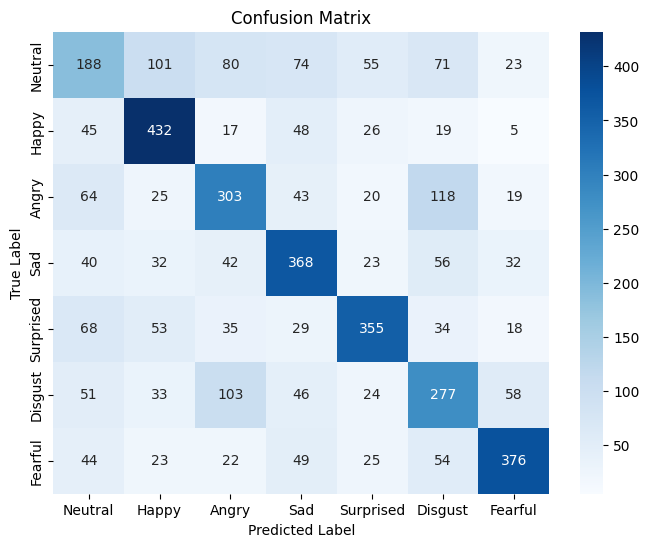

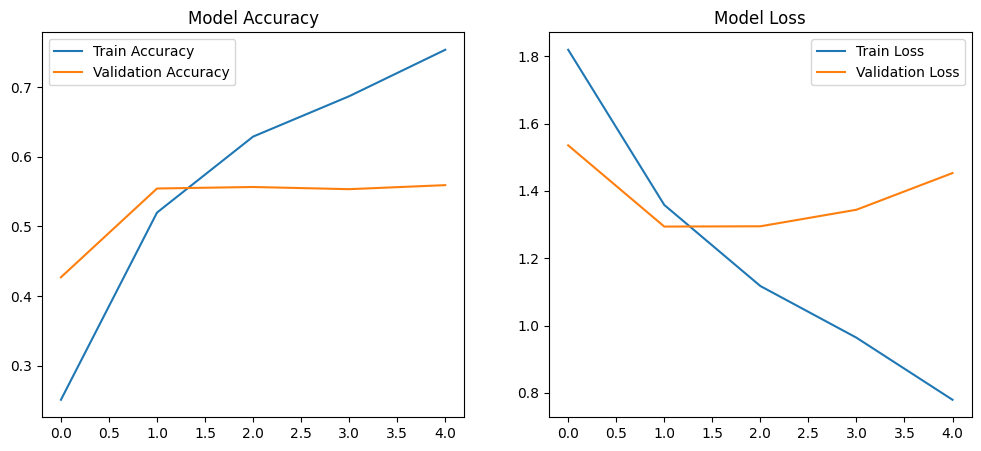

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Emotion: Happy


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/kaggle/input/revdess-balanced-dataset/go_emotions_balanced.csv")

# Handle missing values
df['cleaned_text'] = df['cleaned_text'].astype(str).fillna("")
texts = df['cleaned_text'].tolist()

# Encode labels
emotion_labels = {label: idx for idx, label in enumerate(df["emotion"].unique())}
df["emotion_encoded"] = df["emotion"].map(emotion_labels)

# Hyperparameters
max_vocab_size = 10000
max_seq_length = 50
embedding_dim = 256
lstm_units = 128
dropout_rate = 0.5
num_epochs = 50
batch_size = 64
learning_rate = 0.001
n_classes = len(emotion_labels)

# Tokenization & Padding
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X_sequences = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(X_sequences, maxlen=max_seq_length, padding="pre", truncating="post")

# Convert labels to NumPy array
y = np.array(df["emotion_encoded"])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dropout(dropout_rate),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)


# Train model
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Evaluate the model
print("\nFinal Model Evaluation on Test Set:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)

# Prediction Function
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_seq_length, padding="pre", truncating="post")
    prediction = model.predict(padded)
    predicted_label = np.argmax(prediction)
    emotion = {v: k for k, v in emotion_labels.items()}[predicted_label]
    return emotion

# Test Prediction
custom_text = "I feel so happy today!"
predicted_emotion = predict_emotion(custom_text)
print(f"Predicted Emotion: {predicted_emotion}")


In [4]:

# ✅ Example Prediction
custom_text = "hi everybody"
predicted_emotion = predict_emotion(custom_text)
print(f"Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Emotion: Happy


# **BiLSTM**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.1612 - loss: 1.9338
Epoch 1: val_accuracy improved from -inf to 0.41220, saving model to best_bilstm_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 222ms/step - accuracy: 0.1614 - loss: 1.9335 - val_accuracy: 0.4122 - val_loss: 1.5511 - learning_rate: 0.0010
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4578 - loss: 1.4639
Epoch 2: val_accuracy improved from 0.41220 to 0.54655, saving model to best_bilstm_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 57s 221ms/step - accuracy: 0.4579 - loss: 1.4637 - val_accuracy: 0.5466 - val_loss: 1.3036 - learning_rate: 0.0010
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6264 - loss: 1.1176
Epoch 3: val_accuracy improved from 0.54655 to 0.57091, saving model to best_bilstm_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 57s 220ms/step - accuracy: 0.6264 - loss: 1.1177 - val_accuracy: 0.5709 - val_loss: 1.2645 - learning_rate: 0.0010
Epoch 4/50
260/260 ━━━━━━━━━━━

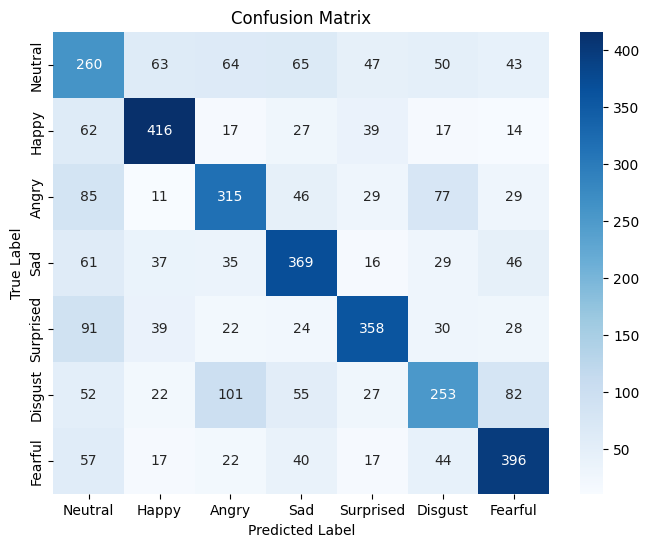

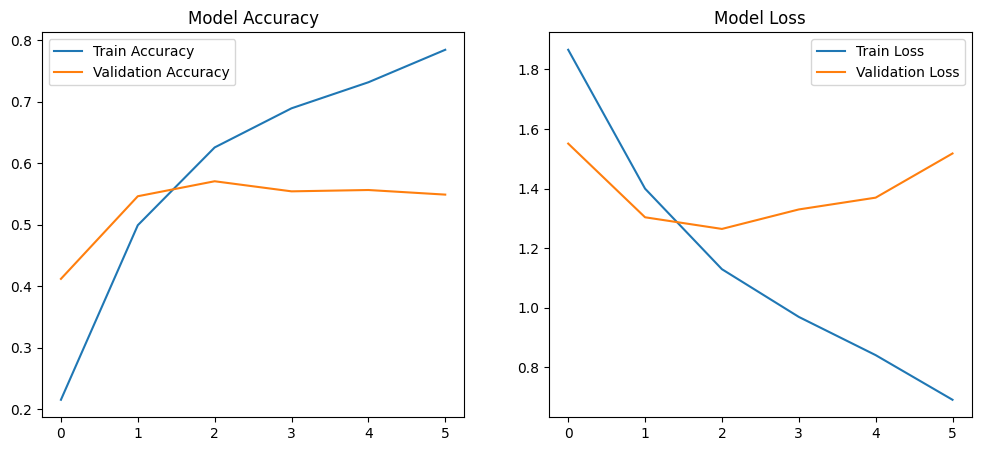

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Emotion: Happy


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/kaggle/input/revdess-balanced-dataset/go_emotions_balanced.csv")

# Handle missing values
df['cleaned_text'] = df['cleaned_text'].astype(str).fillna("")
texts = df['cleaned_text'].tolist()

# Encode labels
emotion_labels = {label: idx for idx, label in enumerate(df["emotion"].unique())}
df["emotion_encoded"] = df["emotion"].map(emotion_labels)

# Hyperparameters
max_vocab_size = 10000
max_seq_length = 50
embedding_dim = 256
lstm_units = 128
dropout_rate = 0.5
num_epochs = 50
batch_size = 64
learning_rate = 0.001
n_classes = len(emotion_labels)

# Tokenization & Padding
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X_sequences = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(X_sequences, maxlen=max_seq_length, padding="pre", truncating="post")

# Convert labels to NumPy array
y = np.array(df["emotion_encoded"])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

# Define BiLSTM Model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(dropout_rate),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_bilstm_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Evaluate the model
print("\nFinal Model Evaluation on Test Set:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_training_history(history)

# Prediction Function
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_seq_length, padding="pre", truncating="post")
    prediction = model.predict(padded)
    predicted_label = np.argmax(prediction)
    emotion = {v: k for k, v in emotion_labels.items()}[predicted_label]
    return emotion

# Test Prediction
custom_text = "I feel so happy today!"
predicted_emotion = predict_emotion(custom_text)
print(f"Predicted Emotion: {predicted_emotion}")

In [6]:

# Test Prediction
custom_text = "this guy is basically the referee in parliament and your right to like him as for the rest in there thats questionable"
predicted_emotion = predict_emotion(custom_text)
print(f"Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Emotion: Neutral


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the trained model
model = tf.keras.models.load_model("best_model.keras")

# Load the tokenizer (Make sure to use the same tokenizer from training)
# You may need to save and load the tokenizer separately if not already done
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)  # Ensure `texts` contains the original dataset texts

# Emotion mapping (Same as used during training)

emotion_labels = {
    0: "Neutral",
    1: "Happy",
    2: "Angry",
    3: "Sad",
    4: "Surprised",
    5: "Disgust",
    6: "Fearful"
}
# Update as per your dataset

# Function for Custom Input Prediction
def predict_custom_emotion():
    while True:
        text = input("\nEnter a sentence (or type 'exit' to quit): ").strip()
        if text.lower() == "exit":
            print("Exiting prediction...")
            break

        # Preprocess the input
        sequence = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(sequence, maxlen=50, padding="pre", truncating="post")

        # Predict
        prediction = model.predict(padded)
        predicted_label = np.argmax(prediction)
        emotion = emotion_labels.get(predicted_label, "Unknown")

        print(f"Predicted Emotion: {emotion}")

# Run the function for custom input
predict_custom_emotion()



Enter a sentence (or type 'exit' to quit):  this guy is basically the referee in parliament and your right to like him as for the rest in there thats questionable


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
Predicted Emotion: Neutral



Enter a sentence (or type 'exit' to quit):  exit


Exiting prediction...


# **Hybrid**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/kaggle/input/revdess-balanced-dataset/go_emotions_balanced.csv")

# Handle missing values
df['cleaned_text'] = df['cleaned_text'].astype(str).fillna("")
texts = df['cleaned_text'].tolist()

# Encode labels
emotion_labels = {label: idx for idx, label in enumerate(df["emotion"].unique())}
df["emotion_encoded"] = df["emotion"].map(emotion_labels)

# Hyperparameters
max_vocab_size = 15000  # Increased vocab size
max_seq_length = 60  # Slightly longer sequences
embedding_dim = 300  # Increased embedding dimension
lstm_units = 256  # Larger LSTM units
dropout_rate = 0.4  # Optimized dropout
num_epochs = 50
batch_size = 64
learning_rate = 0.0005  # Reduced learning rate for stable training
n_classes = len(emotion_labels)

# Tokenization & Padding
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X_sequences = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(X_sequences, maxlen=max_seq_length, padding="pre", truncating="post")

# Convert labels to NumPy array
y = np.array(df["emotion_encoded"])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    SpatialDropout1D(0.3),
    LayerNormalization(),  # Added layer normalization
    Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3),
    Dropout(dropout_rate),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Evaluate the model
print("\nFinal Model Evaluation on Test Set:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_training_history(history)

# **Facial**

# **Resnet**

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 413ms/step - accuracy: 0.1617 - loss: 3.5096 - val_accuracy: 0.2824 - val_loss: 2.2798 - learning_rate: 1.0000e-04
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 56s 122ms/step - accuracy: 0.2074 - loss: 2.7006 - val_accuracy: 0.2579 - val_loss: 2.2909 - learning_rate: 1.0000e-04
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.2266 - loss: 2.5158 - val_accuracy: 0.2920 - val_loss: 2.1319 - learning_rate: 1.0000e-04
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.2359 - loss: 2.4175 - val_accuracy: 0.3075 - val_loss: 2.0547 - learning_rate: 1.0000e-04
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 125ms/step - accuracy: 0.2465 - loss: 2.3380 - val_accuracy: 0.3185 - val_loss: 2.0411 - learning_rate: 1.0000e-04
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.2591 - loss: 2.2603 - val_accuracy: 0.3363 - val_loss: 1.9830 - learning_rate: 1.0000e-04
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step -

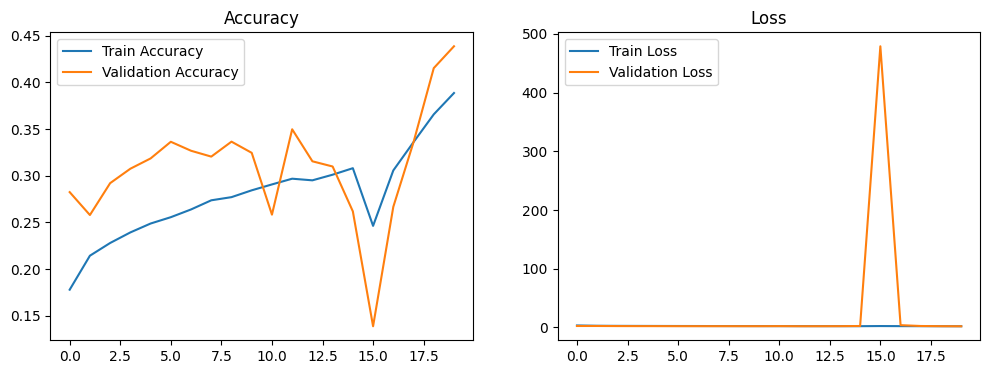

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Input, Conv2D, Add, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def preprocess_image(image):
    # Convert grayscale images to RGB
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def se_block(input_tensor, ratio=32):  # Lighter SE block
    """ Lighter Squeeze-and-Excitation Block """
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Lambda(lambda x: tf.expand_dims(tf.expand_dims(x, 1), 1))(se)
    return Add()([input_tensor, input_tensor * se])

# Paths to the dataset
train_dir = '/kaggle/input/fer2013/train'
val_dir = '/kaggle/input/fer2013/test'

# Optimized Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

# Data Generators with larger batch size
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,  # Increased batch size
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)

# Load pre-trained ResNet50 model with correct input shape
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers with SE blocks and reduced complexity
x = base_model.output

# Apply SE block before flattening
x = se_block(x)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

# Smaller Fully Connected layers
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile with mixed precision for speedup
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with fewer epochs and larger batch size
history = model.fit(
    train_generator,
    epochs=15,  # Reduced training epochs
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping]
)

# Unfreeze base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Fine-tuning with fewer epochs
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    epochs=5,  # Reduced fine-tuning epochs
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping]
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


# **VGG19**

In [9]:
# ================================================
# ✅ IMPORTS
# ================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ================================================
# ✅ CONFIGURATION
# ================================================
BATCH_SIZE = 64
IMG_SIZE = (48, 48)
EPOCHS = 20

# Mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ================================================
# ✅ DATA LOADING AND AUGMENTATION
# ================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/kaggle/input/fer2013/train'
val_dir = '/kaggle/input/fer2013/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# ================================================
# ✅ VGG19 MODEL ARCHITECTURE
# ================================================
# Load VGG19 pre-trained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ================================================
# ✅ COMPILING THE MODEL
# ================================================
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ================================================
# ✅ CALLBACKS
# ================================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# ================================================
# ✅ TRAINING
# ================================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# ================================================
# ✅ FINE-TUNING PHASE
# ================================================
# Unfreeze some base model layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune for a few epochs
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# ================================================
# ✅ EVALUATION
# ================================================
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# ================================================
# ✅ SAVE THE MODEL
# ================================================
model.save('VGG19_FER2013.h5')
print("Model saved successfully!")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 68s 136ms/step - accuracy: 0.1722 - loss: 2.7644 - val_accuracy: 0.2983 - val_loss: 1.8755 - learning_rate: 1.0000e-04
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.2311 - loss: 2.3118 - val_accuracy: 0.3201 - val_loss: 1.8188 - learning_rate: 1.0000e-04
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.2521 - loss: 2.1678 - val_accuracy: 0.3398 - val_loss: 1.7531 - learning_rate: 1.0000e-04
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.2658 - loss: 2.0397 - val_accuracy: 0.3434 - val_loss: 1.7019 - learning_rate: 1.0000e-04
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.2707 - loss: 1.9790 - val_accuracy: 0.3494 - val_loss: 1.6735 - learning_rate: 1.0000e-04
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.

In [17]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Define a custom Cast layer
class CastLayer(Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)  # Adjust dtype as needed

# Load the model with the custom Cast layer
facial_model = tf.keras.models.load_model(
    "/kaggle/working/VGG19_FER2013.h5",
    custom_objects={"Cast": CastLayer}
)

print("Model loaded successfully!")


Model loaded successfully!


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Layer

# Define a custom Cast layer for the facial model
class CastLayer(Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)  # Adjust dtype as needed

# Load pretrained models with the custom Cast layer
speech_model = tf.keras.models.load_model(
    "/kaggle/working/bilstm_model_speech.h5"
)
text_model = tf.keras.models.load_model(
    "/kaggle/working/best_bilstm_model.keras"
)
facial_model = tf.keras.models.load_model(
    "/kaggle/working/VGG19_FER2013.h5",
    custom_objects={"Cast": CastLayer}
)

print("✅ All models loaded successfully!")

# Freeze pretrained models
for model in [speech_model, text_model, facial_model]:
    model.trainable = False

# Define input layers with correct shapes
speech_input = Input(shape=speech_model.input_shape[1:], name="speech_input")
text_input = Input(shape=text_model.input_shape[1:], name="text_input")
facial_input = Input(shape=facial_model.input_shape[1:], name="facial_input")

# Get predictions from each model
speech_out = speech_model(speech_input)
text_out = text_model(text_input)
facial_out = facial_model(facial_input)

# Concatenate outputs
fused = Concatenate()([speech_out, text_out, facial_out])

# Final fusion layer
fusion_output = Dense(7, activation="softmax", name="fusion_output")(fused)  # Assuming 7 emotion classes

# Define final model
fusion_model = Model(inputs=[speech_input, text_input, facial_input], outputs=fusion_output)

# Compile the model
fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Save the fusion model
fusion_model.save("/kaggle/working/fusion_emotion_model.h5")

print("✅ Fusion model created and saved successfully!")


✅ All models loaded successfully!
✅ Fusion model created and saved successfully!


In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects

# Define a custom Cast layer
class CastLayer(Layer):
    def __init__(self, dtype=None, **kwargs):
        super(CastLayer, self).__init__(**kwargs)
        self._dtype_policy = tf.keras.mixed_precision.Policy(dtype) if dtype else None  # Store dtype properly

    def call(self, inputs):
        return tf.cast(inputs, self._dtype_policy.compute_dtype if self._dtype_policy else tf.float32)  

    def get_config(self):
        config = super().get_config()
        config.update({"dtype": self._dtype_policy.name if self._dtype_policy else "float32"})
        return config

# Register the custom Cast layer
get_custom_objects().update({"Cast": CastLayer})

# Now try loading the model
facial_model = tf.keras.models.load_model("/kaggle/working/VGG19_FER2013.h5", compile=False)

print("Model loaded successfully!")


Model loaded successfully!


In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model, load_model

# Load pre-trained models
speech_model = load_model("/kaggle/working/bilstm_model_speech.h5", compile=False)
text_model = load_model("/kaggle/working/best_model.keras", compile=False)
facial_model = load_model("/kaggle/working/VGG19_FER2013.h5", compile=False)

# Function to check if a model is Sequential and extract input/output properly
def get_model_io(model):
    if isinstance(model, tf.keras.Sequential):  
        # Sequential model, manually define input
        model_input = Input(shape=model.input_shape[1:])
        model_output = model(model_input)
    else:  
        # Functional model, directly use its input/output
        model_input = model.input
        model_output = model.output
    return model_input, model_output

# Extract inputs and outputs correctly
speech_input, speech_features = get_model_io(speech_model)
text_input, text_features = get_model_io(text_model)
facial_input, facial_features = get_model_io(facial_model)

# Merge the features
merged = Concatenate()([speech_features, text_features, facial_features])

# Final classification layer
output = Dense(7, activation="softmax", name="fusion_output")(merged)

# Create Fusion Model
fusion_model = Model(inputs=[speech_input, text_input, facial_input], outputs=output)

# Compile the fusion model
fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Summary
fusion_model.summary()


Model: "functional_648"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_37 (Cast)            │ (None, 48, 48, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_layer_15 (CastLayer) │ (None, 48, 48, 3)      │              0 │ cast_37[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 48, 48, 64)     │          1,792 │ cast_layer_15[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 48, 48, 64)     │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 24, 24, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 24, 24, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 24, 24, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 12, 12, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 12, 12, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 12, 12, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 12, 12, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 12, 12, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 6, 6, 256)      │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 6, 6, 512)      │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 6, 6, 512)      │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 6, 6, 512)      │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)

 Total params: 27,494,519 (104.88 MB)

 Trainable params: 25,164,855 (96.00 MB)

 Non-trainable params: 2,329,664 (8.89 MB)

In [58]:
fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model, load_model

# ==============================
# ✅ Load Pretrained Models
# ==============================

speech_model = load_model("/kaggle/working/bilstm_model_speech.h5", compile=False)
text_model = load_model("/kaggle/working/best_model.keras", compile=False)
facial_model = load_model("/kaggle/working/VGG19_FER2013.h5", compile=False)

# ==============================
# ✅ Define Input Layers Manually
# ==============================

speech_input = Input(shape=(200, 122), name="speech_input")  # Match your speech model input shape
text_input = Input(shape=(50,), name="text_input")  # Match text model input shape
facial_input = Input(shape=(48, 48, 3), name="facial_input")  # Match image model input shape

# Get extracted features
speech_features = speech_model(speech_input)
text_features = text_model(text_input)
facial_features = facial_model(facial_input)

# ==============================
# ✅ Merge the Modalities
# ==============================

merged = Concatenate(name="fusion_concat")([speech_features, text_features, facial_features])

# Final classification layer
output = Dense(7, activation="softmax", name="fusion_output")(merged)

# ==============================
# ✅ Create Fusion Model
# ==============================

fusion_model = Model(
    inputs=[speech_input, text_input, facial_input], 
    outputs=output
)

# Compile the fusion model
fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
fusion_model.summary()


Model: "functional_689"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ speech_input (InputLayer) │ (None, 200, 122)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 8)              │      4,173,704 │ speech_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 7)              │      3,160,071 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ facial_input (InputLayer) │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_44 (Cast)            │ (None, 8)              │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_45 (Cast)            │ (None, 7)              │              0 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_25             │ (None, 7)              │     20,160,583 │ facial_input[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fusion_concat             │ (None, 22)             │              0 │ cast_44[0][0],         │
│ (Concatenate)             │                        │                │ cast_45[0][0],         │
│                           │                        │                │ functional_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fusion_output (Dense)     │ (None, 7)              │            161 │ fusion_concat[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,494,519 (104.88 MB)

 Trainable params: 25,164,855 (96.00 MB)

 Non-trainable params: 2,329,664 (8.89 MB)

In [68]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.models import Model

# Load trained models
speech_model = load_model("/kaggle/working/bilstm_model_speech.h5")
text_model = load_model("/kaggle/working/best_model.keras")
facial_model = load_model("/kaggle/working/VGG19_FER2013.h5")

# Define inputs matching trained models' expected input shapes
speech_input = Input(shape=(200, 122), name="speech_input")  # Adjust based on your model
text_input = Input(shape=(50,), name="text_input")           # Adjust based on your model
facial_input = Input(shape=(48, 48, 3), name="facial_input") # Adjust based on your model

# Get model outputs by explicitly calling them
speech_output = speech_model(speech_input)
text_output = text_model(text_input)
facial_output = facial_model(facial_input)

# Concatenate the outputs from all three modalities
fusion = Concatenate()([speech_output, text_output, facial_output])

# Add final classification layer
output_layer = Dense(7, activation='softmax', name="fusion_output")(fusion)

# Define the final fusion model
fusion_model = Model(
    inputs=[speech_input, text_input, facial_input], 
    outputs=output_layer
)

# Compile the model
fusion_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Save the fusion model
fusion_model.save("fusion_model.h5")

print("✅ Multimodal fusion model created and saved successfully.")


✅ Multimodal fusion model created and saved successfully.


In [78]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Define a dummy CastLayer if needed
def CastLayer(x):
    return tf.cast(x, tf.float32)

# Custom objects dictionary
custom_objects = {
    "CastLayer": CastLayer  # Handle unknown CastLayer issue
}

# Load the saved fusion model with custom objects
fusion_model = load_model("/kaggle/working/fusion_model.h5", custom_objects=custom_objects)

print("Fusion model loaded successfully!")


TypeError: Error when deserializing class 'CastLayer' using config={'dtype': 'float16'}.

Exception encountered: super() argument 1 must be type, not function

In [77]:
import tensorflow as tf

# Convert model layers to float32 before saving
for layer in fusion_model.layers:
    if hasattr(layer, 'dtype'):
        layer.dtype = 'float32'

# Save the corrected model
fusion_model.save("/kaggle/working/fusion_model_fixed.h5")


AttributeError: can't set attribute 'dtype'